# Model Training & Evaluation

**Reference:** Paper 1 — OpenFPL (Groos, 2025)

Every model run is automatically logged to `outputs/results/experiment_runs.jsonl`.
At the end, `tracker.summary()` shows the full comparison table across all runs.

## 1. Setup

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

from src.preprocessing import TIER1_FEATURES, TIER2_FEATURES
from src.evaluation import ExperimentTracker

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# One tracker for the whole notebook session
tracker = ExperimentTracker()

print('Setup complete')

Setup complete


## 2. Load Data

In [2]:
data_dir = Path('../data/processed/tier2_2020-21_to_2024_25')

X_train = pd.read_csv(data_dir / 'X_train.csv')
X_test  = pd.read_csv(data_dir / 'X_test.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv')['total_points']
y_test  = pd.read_csv(data_dir / 'y_test.csv')['total_points']

# Full DataFrames for position / category grouping
train_full = pd.read_csv(data_dir / 'train_full.csv')
test_full  = pd.read_csv(data_dir / 'test_full.csv')

# Positions array — always stays aligned with X_test / y_test
test_positions = test_full['position_label'].values

# Available feature columns by tier
tier1_cols = [f for f in TIER1_FEATURES if f in X_train.columns]
tier2_cols = list(X_train.columns)   # already Tier 2

print(f'Train  : {X_train.shape[0]:,} samples')
print(f'Test   : {X_test.shape[0]:,} samples')
print(f'Tier 1 : {len(tier1_cols)} features')
print(f'Tier 2 : {len(tier2_cols)} features')

Train  : 87,940 samples
Test   : 24,020 samples
Tier 1 : 10 features
Tier 2 : 29 features


## 3. Baseline Models

### 3.1 Naive Baseline — Last 5 Average

In [3]:
naive_preds = X_test['form_last_5'].values

tracker.log(
    name='Naive: Last 5 Avg',
    y_true=y_test, y_pred=naive_preds, positions=test_positions,
    config={
        'model': 'Naive',
        'features': 'form_last_5 only',
        'n_features': 1,
        'train_seasons': '2020-21',
        'test_season': '2024-25',
    }
)

  Logged run #001 'Naive: Last 5 Avg'  RMSE=2.2113  MAE=1.1015


{'run_id': 1,
 'name': 'Naive: Last 5 Avg',
 'timestamp': '2026-02-26 20:39:14',
 'model': 'Naive',
 'features': 'form_last_5 only',
 'n_features': 1,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'overall_rmse': 2.211326779959014,
 'overall_mae': 1.1015410768803775,
 'n_test': 24020,
 'Zeros_rmse': 1.0180830627967756,
 'Zeros_mae': 0.3838989494055847,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.8861792177902044,
 'Blanks_mae': 1.3319530443756449,
 'Blanks_n': 6460,
 'Tickers_rmse': 2.086049002162335,
 'Tickers_mae': 1.5965160075329565,
 'Tickers_n': 885,
 'Haulers_rmse': 5.853802458408652,
 'Haulers_mae': 4.933136988370337,
 'Haulers_n': 2207,
 'GK_rmse': 1.7309357580144653,
 'GK_mae': 0.7606462858675248,
 'GK_n': 2486,
 'DEF_rmse': 2.0170057667687575,
 'DEF_mae': 1.0564882146439316,
 'DEF_n': 7976,
 'MID_rmse': 2.162992895886149,
 'MID_mae': 1.0718655873493976,
 'MID_n': 10624,
 'FWD_rmse': 2.421423157841541,
 'FWD_mae': 1.2302949402491736,
 'FWD_n': 2622}

### 3.2 Linear Regression

In [4]:
scaler = StandardScaler()
X_tr_t1 = scaler.fit_transform(X_train)
X_te_t1 = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_tr_t1, y_train)
lr_preds = lr.predict(X_te_t1)

tracker.log(
    name='LinearRegression Tier1',
    y_true=y_test, y_pred=lr_preds, positions=test_positions,
    config={
        'model': 'LinearRegression',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': {'fit_intercept': True, 'scaling': 'StandardScaler'}
    }
)

  Logged run #002 'LinearRegression Tier1'  RMSE=2.1177  MAE=1.1199


{'run_id': 2,
 'name': 'LinearRegression Tier1',
 'timestamp': '2026-02-26 20:41:16',
 'model': 'LinearRegression',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'fit_intercept': True, 'scaling': 'StandardScaler'},
 'overall_rmse': 2.1176775106826113,
 'overall_mae': 1.1198725380474956,
 'n_test': 24020,
 'Zeros_rmse': 0.9069328013449967,
 'Zeros_mae': 0.5263447505557716,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.3643830144453872,
 'Blanks_mae': 1.0444465170701653,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4710502837324926,
 'Tickers_mae': 1.1427481529272212,
 'Tickers_n': 885,
 'Haulers_rmse': 6.090916558305646,
 'Haulers_mae': 5.222349749545122,
 'Haulers_n': 2207,
 'GK_rmse': 1.612018999461925,
 'GK_mae': 0.828306807340933,
 'GK_n': 2486,
 'DEF_rmse': 1.876525905376209,
 'DEF_mae': 1.083340933434576,
 'DEF_n': 7976,
 'MID_rmse': 2.018960054470234,
 'MID_mae': 1.0635683142797916,
 'MID_n': 10624,
 'FWD_rmse': 2.2676187451530576,
 'F

## 4. XGBoost — Experiment with Params

In [5]:
# --- Run 1: XGBoost default-ish ---
xgb_params = dict(n_estimators=100, max_depth=5, learning_rate=0.1,
                  subsample=1.0, colsample_bytree=1.0, random_state=42, n_jobs=-1)

xgb1 = XGBRegressor(**xgb_params)
xgb1.fit(X_train, y_train)
preds = xgb1.predict(X_test)

tracker.log(
    name='XGBoost n100 d5 lr0.1',
    y_true=y_test, y_pred=preds, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'Tier 2',
        'n_features': len(tier2_cols),
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': xgb_params,
    }
)

  Logged run #003 'XGBoost n100 d5 lr0.1'  RMSE=2.1097  MAE=1.0907


{'run_id': 3,
 'name': 'XGBoost n100 d5 lr0.1',
 'timestamp': '2026-02-26 20:41:40',
 'model': 'XGBoost',
 'features': 'Tier 2',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 100,
  'max_depth': 5,
  'learning_rate': 0.1,
  'subsample': 1.0,
  'colsample_bytree': 1.0,
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1097270436923115,
 'overall_mae': 1.0906931048820665,
 'n_test': 24020,
 'Zeros_rmse': 0.948965804771849,
 'Zeros_mae': 0.47802111002907094,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.4509724992019204,
 'Blanks_mae': 1.0872570534267005,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4761431453795655,
 'Tickers_mae': 1.154360987216571,
 'Tickers_n': 885,
 'Haulers_rmse': 5.958397941416582,
 'Haulers_mae': 5.091594436132076,
 'Haulers_n': 2207,
 'GK_rmse': 1.6591963868029236,
 'GK_mae': 0.8144717454462225,
 'GK_n': 2486,
 'DEF_rmse': 1.8778984490891029,
 'DEF_mae': 1.0579807265768089,
 'DEF_n': 7976,
 'MID_rmse': 2.0248169956

In [6]:
# --- Run 2: XGBoost more trees, lower lr ---
xgb_params2 = dict(n_estimators=300, max_depth=5, learning_rate=0.05,
                   subsample=0.85, colsample_bytree=0.85, random_state=42, n_jobs=-1)

xgb2 = XGBRegressor(**xgb_params2)
xgb2.fit(X_train, y_train)
preds2 = xgb2.predict(X_test)

tracker.log(
    name='XGBoost n300 d5 lr0.05',
    y_true=y_test, y_pred=preds2, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': xgb_params2,
    }
)

  Logged run #004 'XGBoost n300 d5 lr0.05'  RMSE=2.1151  MAE=1.0906


{'run_id': 4,
 'name': 'XGBoost n300 d5 lr0.05',
 'timestamp': '2026-02-26 20:41:57',
 'model': 'XGBoost',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 300,
  'max_depth': 5,
  'learning_rate': 0.05,
  'subsample': 0.85,
  'colsample_bytree': 0.85,
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1151369057945306,
 'overall_mae': 1.0906023018876052,
 'n_test': 24020,
 'Zeros_rmse': 0.9393972417350914,
 'Zeros_mae': 0.47558753990725866,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.4464099582894578,
 'Blanks_mae': 1.0803669893698935,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.5117731201595557,
 'Tickers_mae': 1.1778526309540884,
 'Tickers_n': 885,
 'Haulers_rmse': 5.9887991040593755,
 'Haulers_mae': 5.117306948000988,
 'Haulers_n': 2207,
 'GK_rmse': 1.6473481028076151,
 'GK_mae': 0.8077729528003551,
 'GK_n': 2486,
 'DEF_rmse': 1.8722328526410332,
 'DEF_mae': 1.0504480140232795,
 'DEF_n': 7976,
 'MID_rmse': 2.032999

In [7]:
# --- Run 3: XGBoost deeper trees ---
xgb_params3 = dict(n_estimators=300, max_depth=7, learning_rate=0.05,
                   subsample=0.85, colsample_bytree=0.7, random_state=42, n_jobs=-1)

xgb3 = XGBRegressor(**xgb_params3)
xgb3.fit(X_train, y_train)
preds3 = xgb3.predict(X_test)

tracker.log(
    name='XGBoost n300 d7 lr0.05',
    y_true=y_test, y_pred=preds3, positions=test_positions,
    config={
        'model': 'XGBoost',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': xgb_params3,
    }
)

  Logged run #005 'XGBoost n300 d7 lr0.05'  RMSE=2.1049  MAE=1.0959


{'run_id': 5,
 'name': 'XGBoost n300 d7 lr0.05',
 'timestamp': '2026-02-26 20:42:06',
 'model': 'XGBoost',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 300,
  'max_depth': 7,
  'learning_rate': 0.05,
  'subsample': 0.85,
  'colsample_bytree': 0.7,
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1048714207991144,
 'overall_mae': 1.095878329035457,
 'n_test': 24020,
 'Zeros_rmse': 0.9707294494009203,
 'Zeros_mae': 0.4844542054292506,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.5241328835081207,
 'Blanks_mae': 1.1191527608260528,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.5495161791454208,
 'Tickers_mae': 1.197411086523937,
 'Tickers_n': 885,
 'Haulers_rmse': 5.854892829797957,
 'Haulers_mae': 4.995232611133345,
 'Haulers_n': 2207,
 'GK_rmse': 1.6619797964052792,
 'GK_mae': 0.8112863308575142,
 'GK_n': 2486,
 'DEF_rmse': 1.884466722954426,
 'DEF_mae': 1.06067893933318,
 'DEF_n': 7976,
 'MID_rmse': 2.05127358444624

## 5. Random Forest — Experiment with Params

In [8]:
# --- Run 1: RF default ---
rf_params = dict(n_estimators=100, max_depth=None, min_samples_leaf=1,
                 max_features='sqrt', random_state=42, n_jobs=-1)

rf1 = RandomForestRegressor(**rf_params)
rf1.fit(X_train, y_train)
rf_preds1 = rf1.predict(X_test)

tracker.log(
    name='RF n100 depth=None',
    y_true=y_test, y_pred=rf_preds1, positions=test_positions,
    config={
        'model': 'RandomForest',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': rf_params,
    }
)

  Logged run #006 'RF n100 depth=None'  RMSE=2.1515  MAE=1.1766


{'run_id': 6,
 'name': 'RF n100 depth=None',
 'timestamp': '2026-02-26 20:42:32',
 'model': 'RandomForest',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 100,
  'max_depth': None,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.151545842496267,
 'overall_mae': 1.1765744480391997,
 'n_test': 24020,
 'Zeros_rmse': 1.086800729812063,
 'Zeros_mae': 0.572577256407272,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.6376861334875044,
 'Blanks_mae': 1.2597565341310963,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4409219035754124,
 'Tickers_mae': 1.1396045197740112,
 'Tickers_n': 885,
 'Haulers_rmse': 5.827150377529953,
 'Haulers_mae': 4.907427859408376,
 'Haulers_n': 2207,
 'GK_rmse': 1.6849543921727808,
 'GK_mae': 0.8680425302327958,
 'GK_n': 2486,
 'DEF_rmse': 1.9292672742724006,
 'DEF_mae': 1.1538615627584508,
 'DEF_n': 7976,
 'MID_rmse': 2.058165678847452,
 'MID_mae': 1

In [9]:
# --- Run 2: RF regularised (max_depth, min_samples_leaf) ---
rf_params2 = dict(n_estimators=300, max_depth=10, min_samples_leaf=3,
                  max_features='sqrt', random_state=42, n_jobs=-1)

rf2 = RandomForestRegressor(**rf_params2)
rf2.fit(X_train, y_train)
rf_preds2 = rf2.predict(X_test)

tracker.log(
    name='RF n300 depth=10 leaf=3',
    y_true=y_test, y_pred=rf_preds2, positions=test_positions,
    config={
        'model': 'RandomForest',
        'features': 'all',
        'n_features': X_train.shape[1],
        'train_seasons': '2020-21',
        'test_season': '2024-25',
        'params': rf_params2,
    }
)

  Logged run #007 'RF n300 depth=10 leaf=3'  RMSE=2.1261  MAE=1.0958


{'run_id': 7,
 'name': 'RF n300 depth=10 leaf=3',
 'timestamp': '2026-02-26 20:42:42',
 'model': 'RandomForest',
 'features': 'all',
 'n_features': 29,
 'train_seasons': '2020-21',
 'test_season': '2024-25',
 'params': {'n_estimators': 300,
  'max_depth': 10,
  'min_samples_leaf': 3,
  'max_features': 'sqrt',
  'random_state': 42,
  'n_jobs': -1},
 'overall_rmse': 2.1260528971630177,
 'overall_mae': 1.0958169630971908,
 'n_test': 24020,
 'Zeros_rmse': 0.9321051133774555,
 'Zeros_mae': 0.48276593976728144,
 'Zeros_n': 14468,
 'Blanks_rmse': 1.3863361929315823,
 'Blanks_mae': 1.0642731579317009,
 'Blanks_n': 6460,
 'Tickers_rmse': 1.4072205795052872,
 'Tickers_mae': 1.0958772339266265,
 'Tickers_n': 885,
 'Haulers_rmse': 6.089297114202441,
 'Haulers_mae': 5.206982276745648,
 'Haulers_n': 2207,
 'GK_rmse': 1.5998028695089792,
 'GK_mae': 0.7725750766231192,
 'GK_n': 2486,
 'DEF_rmse': 1.8823628789215094,
 'DEF_mae': 1.0811365300243325,
 'DEF_n': 7976,
 'MID_rmse': 2.0210682674704703,
 'MID

## 6. Results — Full Run Table

In [10]:
# RMSE table
tracker.summary('rmse')


  EXPERIMENT RUNS — RMSE
 run_id                    name           timestamp  overall_rmse  Zeros_rmse  Blanks_rmse  Tickers_rmse  Haulers_rmse  GK_rmse  DEF_rmse  MID_rmse  FWD_rmse
      1       Naive: Last 5 Avg 2026-02-26 20:39:14        2.2113      1.0181       1.8862        2.0860        5.8538   1.7309    2.0170    2.1630    2.4214
      2  LinearRegression Tier1 2026-02-26 20:41:16        2.1177      0.9069       1.3644        1.4711        6.0909   1.6120    1.8765    2.0190    2.2676
      3   XGBoost n100 d5 lr0.1 2026-02-26 20:41:40        2.1097      0.9490       1.4510        1.4761        5.9584   1.6592    1.8779    2.0248    2.2533
      4  XGBoost n300 d5 lr0.05 2026-02-26 20:41:57        2.1151      0.9394       1.4464        1.5118        5.9888   1.6473    1.8722    2.0330    2.2435
      5  XGBoost n300 d7 lr0.05 2026-02-26 20:42:06        2.1049      0.9707       1.5241        1.5495        5.8549   1.6620    1.8845    2.0513    2.2716
      6      RF n100 depth

In [11]:
# MAE table
tracker.summary('mae')


  EXPERIMENT RUNS — MAE
 run_id                    name           timestamp  overall_mae  Zeros_mae  Blanks_mae  Tickers_mae  Haulers_mae  GK_mae  DEF_mae  MID_mae  FWD_mae
      1       Naive: Last 5 Avg 2026-02-26 20:39:14       1.1015     0.3839      1.3320       1.5965       4.9331  0.7606   1.0565   1.0719   1.2303
      2  LinearRegression Tier1 2026-02-26 20:41:16       1.1199     0.5263      1.0444       1.1427       5.2223  0.8283   1.0833   1.0636   1.2338
      3   XGBoost n100 d5 lr0.1 2026-02-26 20:41:40       1.0907     0.4780      1.0873       1.1544       5.0916  0.8145   1.0580   1.0324   1.2008
      4  XGBoost n300 d5 lr0.05 2026-02-26 20:41:57       1.0906     0.4756      1.0804       1.1779       5.1173  0.8078   1.0504   1.0373   1.2023
      5  XGBoost n300 d7 lr0.05 2026-02-26 20:42:06       1.0959     0.4845      1.1192       1.1974       4.9952  0.8113   1.0607   1.0470   1.2191
      6      RF n100 depth=None 2026-02-26 20:42:32       1.1766     0.5726      

In [12]:
# Best run by overall MAE
best = tracker.best_run('overall_mae')
print(f"Best run by MAE: #{int(best['run_id'])} '{best['name']}'")
print(f"  overall_rmse={best['overall_rmse']:.4f}  overall_mae={best['overall_mae']:.4f}")

Best run by MAE: #4 'XGBoost n300 d5 lr0.05'
  overall_rmse=2.1151  overall_mae=1.0906


In [13]:
# Paper 1 benchmarks for reference
paper1 = {
    'run_id': '—', 'name': 'Paper1: Last5 Baseline',
    'overall_rmse': None, 'overall_mae': None,
    'Zeros_rmse': 0.791, 'Blanks_rmse': 1.400, 'Tickers_rmse': 2.136, 'Haulers_rmse': 5.613,
    'Zeros_mae':  0.270, 'Blanks_mae':  0.652, 'Tickers_mae':  1.645, 'Haulers_mae':  4.709,
}
paper2 = {
    'run_id': '—', 'name': 'Paper1: OpenFPL',
    'overall_rmse': None, 'overall_mae': None,
    'Zeros_rmse': 0.818, 'Blanks_rmse': 1.291, 'Tickers_rmse': 1.517, 'Haulers_rmse': 5.142,
    'Zeros_mae':  0.427, 'Blanks_mae':  0.749, 'Tickers_mae':  1.127, 'Haulers_mae':  4.317,
}

all_runs = tracker.load_runs()
paper_df = pd.DataFrame([paper1, paper2])

cat_rmse_cols = ['name', 'overall_rmse', 'Zeros_rmse', 'Blanks_rmse', 'Tickers_rmse', 'Haulers_rmse']
cat_mae_cols  = ['name', 'overall_mae',  'Zeros_mae',  'Blanks_mae',  'Tickers_mae',  'Haulers_mae']

combined_rmse = pd.concat([paper_df[cat_rmse_cols], all_runs[cat_rmse_cols]], ignore_index=True)
combined_mae  = pd.concat([paper_df[cat_mae_cols],  all_runs[cat_mae_cols]],  ignore_index=True)

print('RMSE BY RETURN CATEGORY (our runs + Paper 1)')
print(combined_rmse.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

print('\nMAE BY RETURN CATEGORY (our runs + Paper 1)')
print(combined_mae.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

RMSE BY RETURN CATEGORY (our runs + Paper 1)
                   name  overall_rmse  Zeros_rmse  Blanks_rmse  Tickers_rmse  Haulers_rmse
 Paper1: Last5 Baseline           NaN      0.7910       1.4000        2.1360        5.6130
        Paper1: OpenFPL           NaN      0.8180       1.2910        1.5170        5.1420
      Naive: Last 5 Avg        2.2113      1.0181       1.8862        2.0860        5.8538
 LinearRegression Tier1        2.1177      0.9069       1.3644        1.4711        6.0909
  XGBoost n100 d5 lr0.1        2.1097      0.9490       1.4510        1.4761        5.9584
 XGBoost n300 d5 lr0.05        2.1151      0.9394       1.4464        1.5118        5.9888
 XGBoost n300 d7 lr0.05        2.1049      0.9707       1.5241        1.5495        5.8549
     RF n100 depth=None        2.1515      1.0868       1.6377        1.4409        5.8272
RF n300 depth=10 leaf=3        2.1261      0.9321       1.3863        1.4072        6.0893

MAE BY RETURN CATEGORY (our runs + Paper 1)


## 7. Visualisations

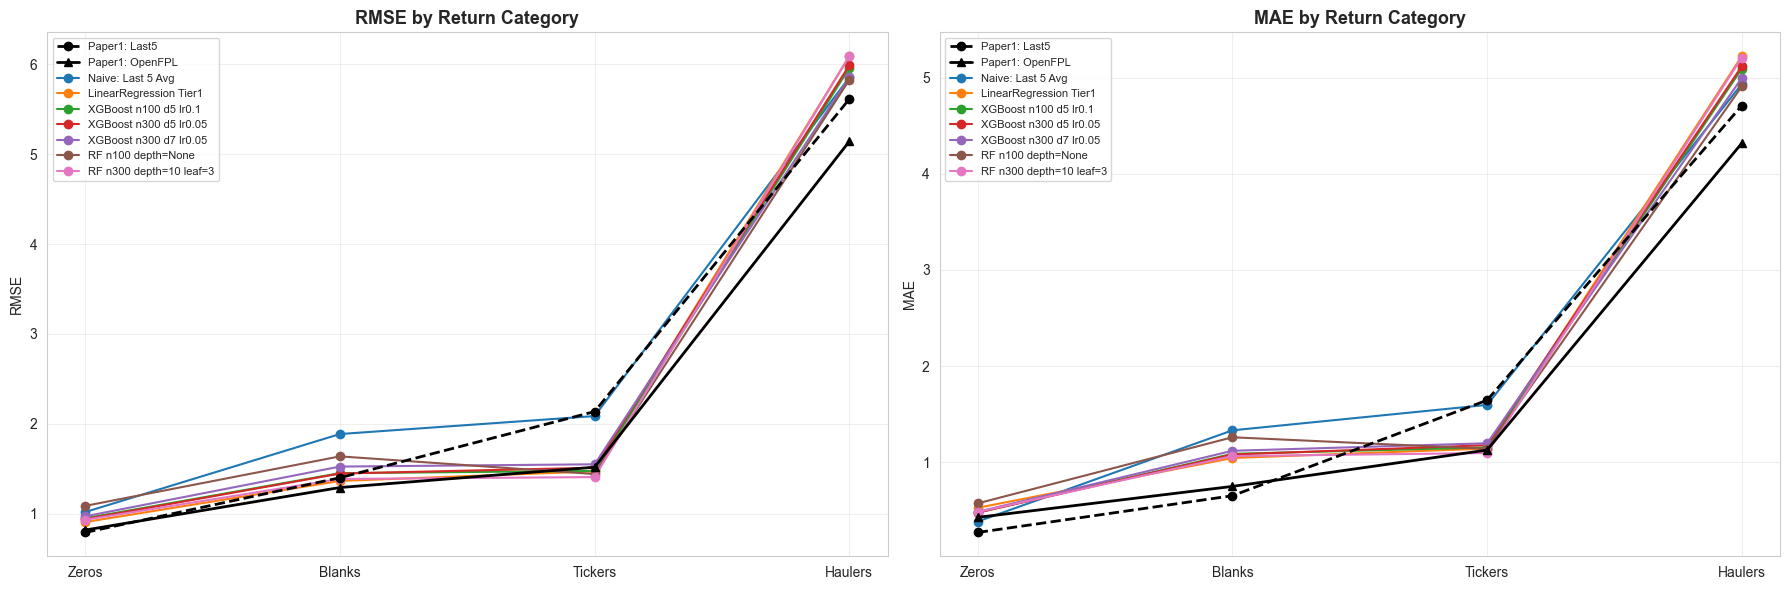

In [14]:
# RMSE by category — all runs + Paper 1
categories = ['Zeros', 'Blanks', 'Tickers', 'Haulers']
all_runs = tracker.load_runs()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, metric in zip(axes, ['rmse', 'mae']):
    cols = [f'{c}_{metric}' for c in categories]

    # Paper 1 lines first
    ax.plot(categories, [paper1[c] for c in cols], 'k--o', lw=2, label='Paper1: Last5', zorder=5)
    ax.plot(categories, [paper2[c] for c in cols], 'k-^',  lw=2, label='Paper1: OpenFPL', zorder=5)

    # Our runs
    for _, row in all_runs.iterrows():
        vals = [row.get(c) for c in cols]
        ax.plot(categories, vals, '-o', lw=1.5, ms=6, label=row['name'])

    ax.set_title(f'{metric.upper()} by Return Category', fontweight='bold', fontsize=13)
    ax.set_ylabel(metric.upper())
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

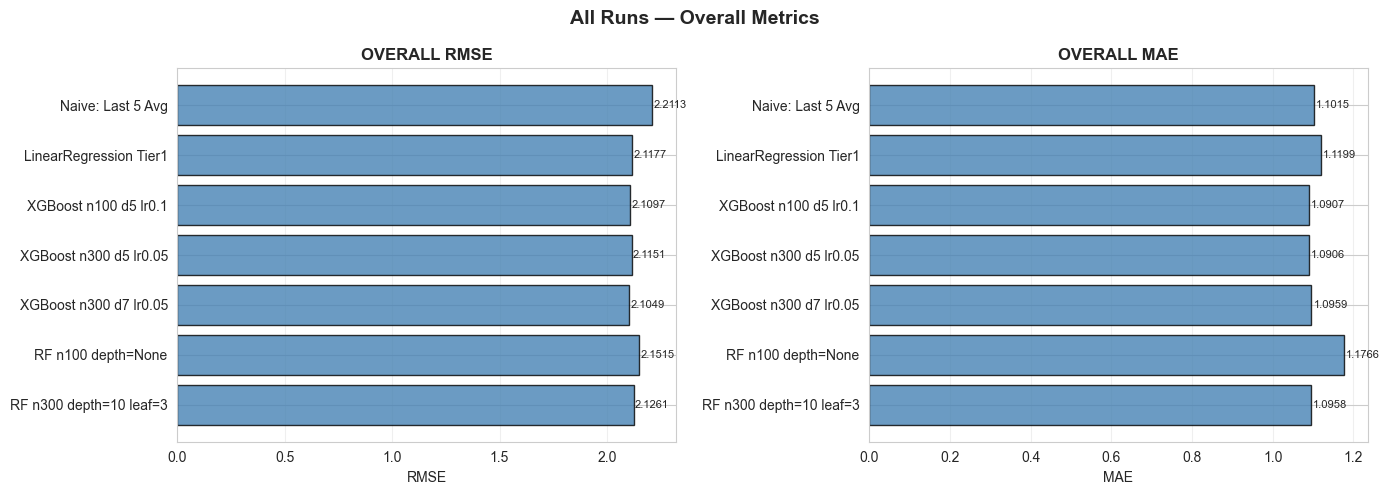

In [15]:
# Overall RMSE / MAE comparison bar chart
all_runs = tracker.load_runs()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric in zip(axes, ['overall_rmse', 'overall_mae']):
    ax.barh(all_runs['name'], all_runs[metric], color='steelblue', alpha=0.8, edgecolor='black')
    ax.set_title(metric.replace('_', ' ').upper(), fontweight='bold')
    ax.set_xlabel(metric.split('_')[1].upper())
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(all_runs[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8)

plt.suptitle('All Runs — Overall Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Best XGBoost run: #4 'XGBoost n300 d5 lr0.05'


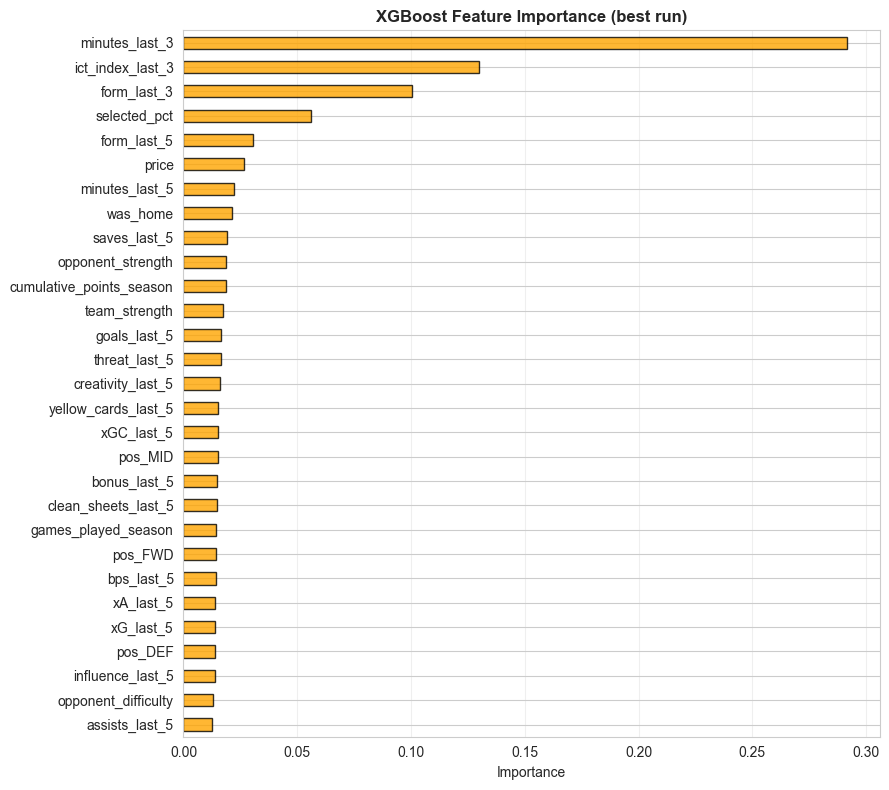

In [16]:
# Feature importance for best XGBoost run (by MAE)
xgb_runs = all_runs[all_runs['model'] == 'XGBoost']
best_xgb_idx = xgb_runs['overall_mae'].idxmin()
print(f"Best XGBoost run: #{int(all_runs.loc[best_xgb_idx, 'run_id'])} '{all_runs.loc[best_xgb_idx, 'name']}'")

# Use the last trained XGBoost (you may need to retrain if restarting the kernel)
# xgb2 = best based on the runs above — adjust if needed
best_xgb = xgb2   # change this if a different run is best

imp = pd.Series(best_xgb.feature_importances_, index=tier2_cols).sort_values()
fig, ax = plt.subplots(figsize=(9, 8))
imp.plot(kind='barh', ax=ax, color='orange', alpha=0.8, edgecolor='black')
ax.set_title('XGBoost Feature Importance (best run)', fontweight='bold')
ax.set_xlabel('Importance')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Load All Historical Runs

Runs accumulate across notebook sessions. Run this cell any time to see everything.

In [17]:
from src.evaluation import load_runs

all_runs_df = load_runs()
print(f'Total runs logged so far: {len(all_runs_df)}')
all_runs_df

Total runs logged so far: 7


,run_id,name,timestamp,model,features,n_features,train_seasons,test_season,overall_rmse,overall_mae,...,params.scaling,params.n_estimators,params.max_depth,params.learning_rate,params.subsample,params.colsample_bytree,params.random_state,params.n_jobs,params.min_samples_leaf,params.max_features
0,1,Naive: Last 5 Avg,2026-02-26 20:39:14,Naive,form_last_5 only,1,2020-21,2024-25,2.211327,1.101541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,LinearRegression Tier1,2026-02-26 20:41:16,LinearRegression,all,29,2020-21,2024-25,2.117678,1.119873,...,StandardScaler,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,XGBoost n100 d5 lr0.1,2026-02-26 20:41:40,XGBoost,Tier 2,29,2020-21,2024-25,2.109727,1.090693,...,NaN,100.0,5.0,0.10,1.00,1.00,42.0,-1.0,NaN,NaN
3,4,XGBoost n300 d5 lr0.05,2026-02-26 20:41:57,XGBoost,all,29,2020-21,2024-25,2.115137,1.090602,...,NaN,300.0,5.0,0.05,0.85,0.85,42.0,-1.0,NaN,NaN
4,5,XGBoost n300 d7 lr0.05,2026-02-26 20:42:06,XGBoost,all,29,2020-21,2024-25,2.104871,1.095878,...,NaN,300.0,7.0,0.05,0.85,0.70,42.0,-1.0,NaN,NaN
5,6,RF n100 depth=None,2026-02-26 20:42:32,RandomForest,all,29,2020-21,2024-25,2.151546,1.176574,...,NaN,100.0,NaN,NaN,NaN,NaN,42.0,-1.0,1.0,sqrt
6,7,RF n300 depth=10 leaf=3,2026-02-26 20:42:42,RandomForest,all,29,2020-21,2024-25,2.126053,1.095817,...,NaN,300.0,10.0,NaN,NaN,NaN,42.0,-1.0,3.0,sqrt


In [18]:
# Clean pivot: runs × metrics (useful for sharing / exporting)
pivot = tracker.comparison_table('rmse')
pivot

,,Zeros_rmse,Blanks_rmse,Tickers_rmse,Haulers_rmse,GK_rmse,DEF_rmse,MID_rmse,FWD_rmse,overall_rmse
run_id,name,,,,,,,,,
1,Naive: Last 5 Avg,1.018083,1.886179,2.086049,5.853802,1.730936,2.017006,2.162993,2.421423,2.211327
2,LinearRegression Tier1,0.906933,1.364383,1.471050,6.090917,1.612019,1.876526,2.018960,2.267619,2.117678
3,XGBoost n100 d5 lr0.1,0.948966,1.450972,1.476143,5.958398,1.659196,1.877898,2.024817,2.253333,2.109727
4,XGBoost n300 d5 lr0.05,0.939397,1.446410,1.511773,5.988799,1.647348,1.872233,2.033000,2.243538,2.115137
5,XGBoost n300 d7 lr0.05,0.970729,1.524133,1.549516,5.854893,1.661980,1.884467,2.051274,2.271563,2.104871
6,RF n100 depth=None,1.086801,1.637686,1.440922,5.827150,1.684954,1.929267,2.058166,2.281877,2.151546
7,RF n300 depth=10 leaf=3,0.932105,1.386336,1.407221,6.089297,1.599803,1.882363,2.021068,2.246147,2.126053


In [ ]:
# Uncomment to reset and start fresh (deletes all logged runs!)
# tracker.clear()